# Repeat until success

This notebook demonstrates the current capabilities of IBM dynamic-circuit backends to use mid-circuit measurements to produce a circuit that repeatedly attempts its setup until a syndrome measurement reveals that it has been successful.

We will use the full dynamic-circuit paths through Qiskit all the way to the hardware, including the standard "`transpile` + `backend.run`" sequence in Qiskit Terra that is familiar.  We will also see Aer's capability for simulating circuits with classical control flow.

## Circuit definition

For this tutorial, we will build an abstract circuit that uses the non-parametrized gate set $\{H,\,X,\,S,\,\text{Toffoli}\}$ to construct a heralded $R_X(\theta)$ gate on a target qubit, where $\theta$ satisfies $\cos\theta = \frac35$.  This example is modified slightly from Nielsen and Chuang, _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, exercise 4.41.  Each iteration of the circuit only has a finite chance of success, but successes are heralded, so we will use our dynamic-circuit capabilities to repeat the setup until it succeeds.

_Note:_ for real-world usage, it is better to insert the gates you want onto the circuit directly, and let Qiskit's `transpile` function automatically synthesize them into a suitable basis for the target hardware.  We are using this purely as an educational example.

We first initialize our circuit in Qiskit.  We will create the probabalistic $R_X(\theta)$ gate on one qubit, using two auxiliary controlling qubits, which we will measure throughout the execution of the circuit.  We begin by creating separate quantum and classical registers for these components.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

max_trials = 2

controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

A single trial of the probabalistic gate has the following form:

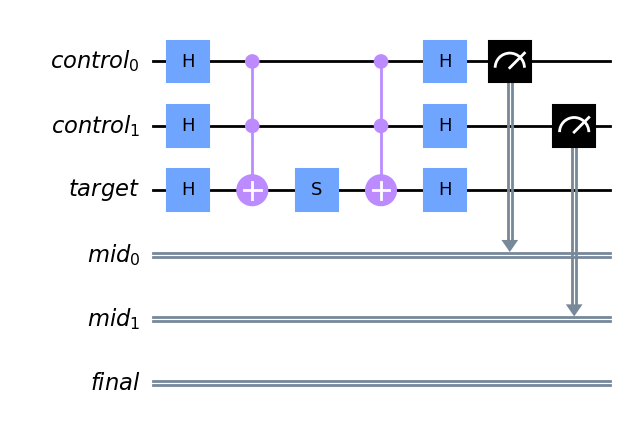

In [2]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)


example = base.copy_empty_like()
trial(example, target, controls, mid_measure)
example.draw("mpl", cregbundle=False)

If _both_ measurements of the control bits return $0$, the applied gate is $R_X(\theta)$ with $\cos\theta = \frac35$.  If any of the measurements are $1$, then the applied gate is simply $X$, which is a failure.  This is our heralding; we can tell from the measurement whether we applied the correct gate, without disturbing the coherence of the target qubit.  Without fully reproducing the mathematics, the success probability of this gate is:
$$
P_{\text{success}} = \frac{{\lvert 3 + i\rvert}^2}{{\lvert 3 + i\rvert}^2 + 3{\lvert 1 - i\rvert}^2} = \frac58
$$

If there is a failure, we should reset the dirty state, and start again.  Since we know what is applied in the case of a failure, we can use this knowledge to perform the reset efficiently, without using a general hardware reset.  For the two auxiliary qubits, this is just an $X$ gate conditioned on its respective measurement being $1$.  IBM hardware has a special fast-path for when qubits are conditioned on the result of their own measurement, so this is more efficient than most control flow.

We can do this conditional measurement in Qiskit either with the older `circuit.x(0).c_if(<condition>)` form, or the newer `with circuit.if_test(<condition>)` form.  For single operations like these, either will work for now, but it is beneficial to start adopting the new form, since the old form will eventually be deprecated, and the new one offers far more power when dealing with multiple operations, as we will see later.  For now, the reset of the controls looks like this:

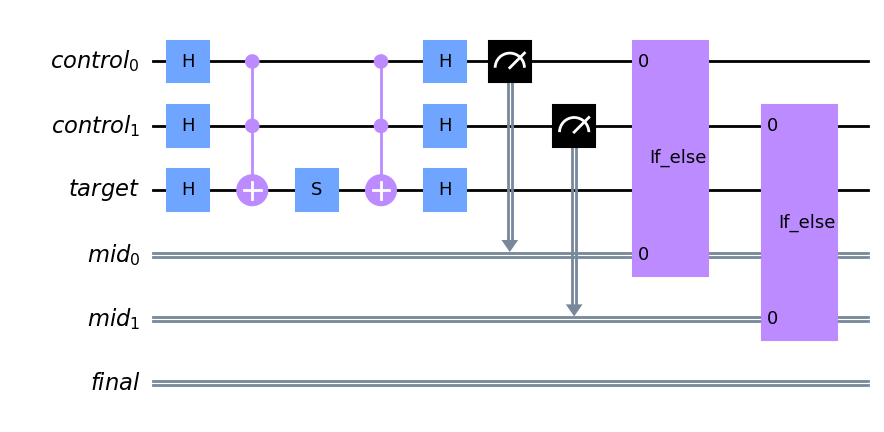

In [3]:
def reset_controls(circuit, controls, measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])


reset_controls(example, controls, mid_measure)
example.draw("mpl", cregbundle=False)

So far, we have drawn a dummy circuit, to show the intermediate steps.  Let us now construct the whole circuit in one cell.

We now see the full power of the new-style `with circuit.if_test` blocks compared to the old `c_if` form.  Not only can you include multiple operations in the same single-condition check, but you can also use the `else` branch.  Right now, Qiskit can only represent very basic equality conditions.  The backend is capable of significantly more than this, which you can test out by using the OpenQASM 3 string input forms discussed in the [Dynamic circuits basics with OpenQASM 3 notebook](https://quantum-computing.ibm.com/lab/files/qiskit-tutorials/dynamic-circuits/Dynamic-Circuits-basics-with-OpenQASM3.ipynb).

Of note is that Qiskit cannot directly represent an _inequality_ condition, which is what we require; we only need to do the repeat if the mid-circuit measurement result was not the bitstring `"00"`.  Instead, we can create an `if` statement with the condition `mid_measure == "00"`, pass an empty block, and then use the `else` branch to perform the logic we want.

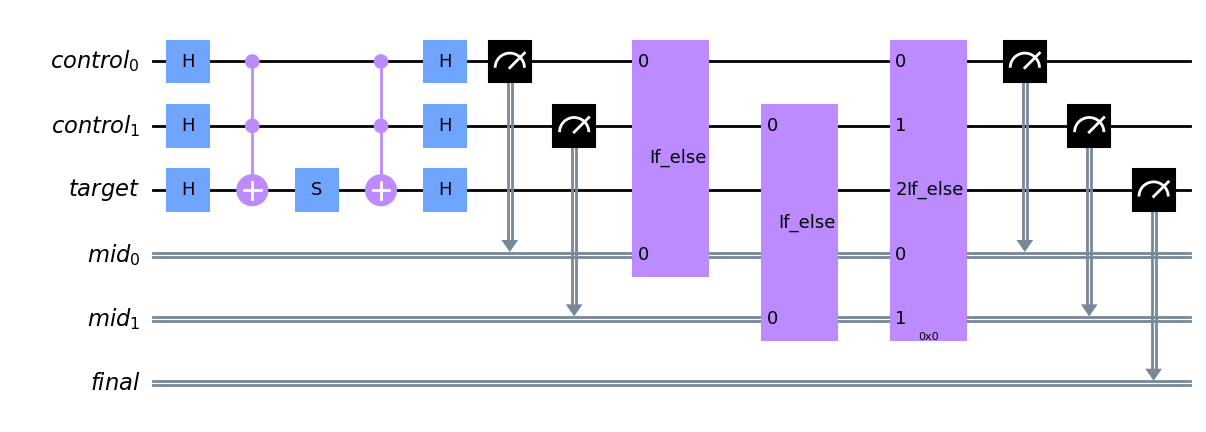

In [4]:
# Create a clean circuit with the same structure (bits, registers, etc)
# as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls
# are guaranteed to start in the |0> state.
trial(circuit, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        # First reset the target.
        circuit.x(target)
        # Then repeat the trial.
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

## Run on hardware

We have defined a relatively complicated circuit now, and one that contains three-qubit gates.  This cannot run directly on our hardware; it must be "transpiled" by Qiskit into a form that only uses the basis gates of the underlying hardware and respects its connectivity.

First, we do the standard setup to retrieve a backend to run on.

In [5]:
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider()

hub = "<hub>"
group = "<group>"
project = "<project>"
hgp = f"{hub}/{group}/{project}"
backend_name = "<backend name>"

backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using {backend.name}")

To prepare the circuit to run on real hardware, we use Qiskit's `transpile` function.  The defaults are all sensible, so it simply requires the input circuit and the target backend.  All of Qiskit's normal transpilation stages should work with the dynamic circuit: a suitable subset of the available qubits will be chosen; the input gates will all be translated into a basis that the hardware can actually run; the resulting two-qubit gates will be swap-mapped (routed) so that only physically linked qubits are interacted; and the resulting output undergoes some quantum optimizations to remove unnecessary gates and optimize the remaining ones.

By not specifying an `optimization_level` argument to `transpile`, we implicitly use level 1, which has light quantum optimization.  For now, levels 2 and 3 do not support the dynamic circuits path; some of the optimizations used at those levels are not fully control-flow-aware.  For our circuit, the difference is not especially large.

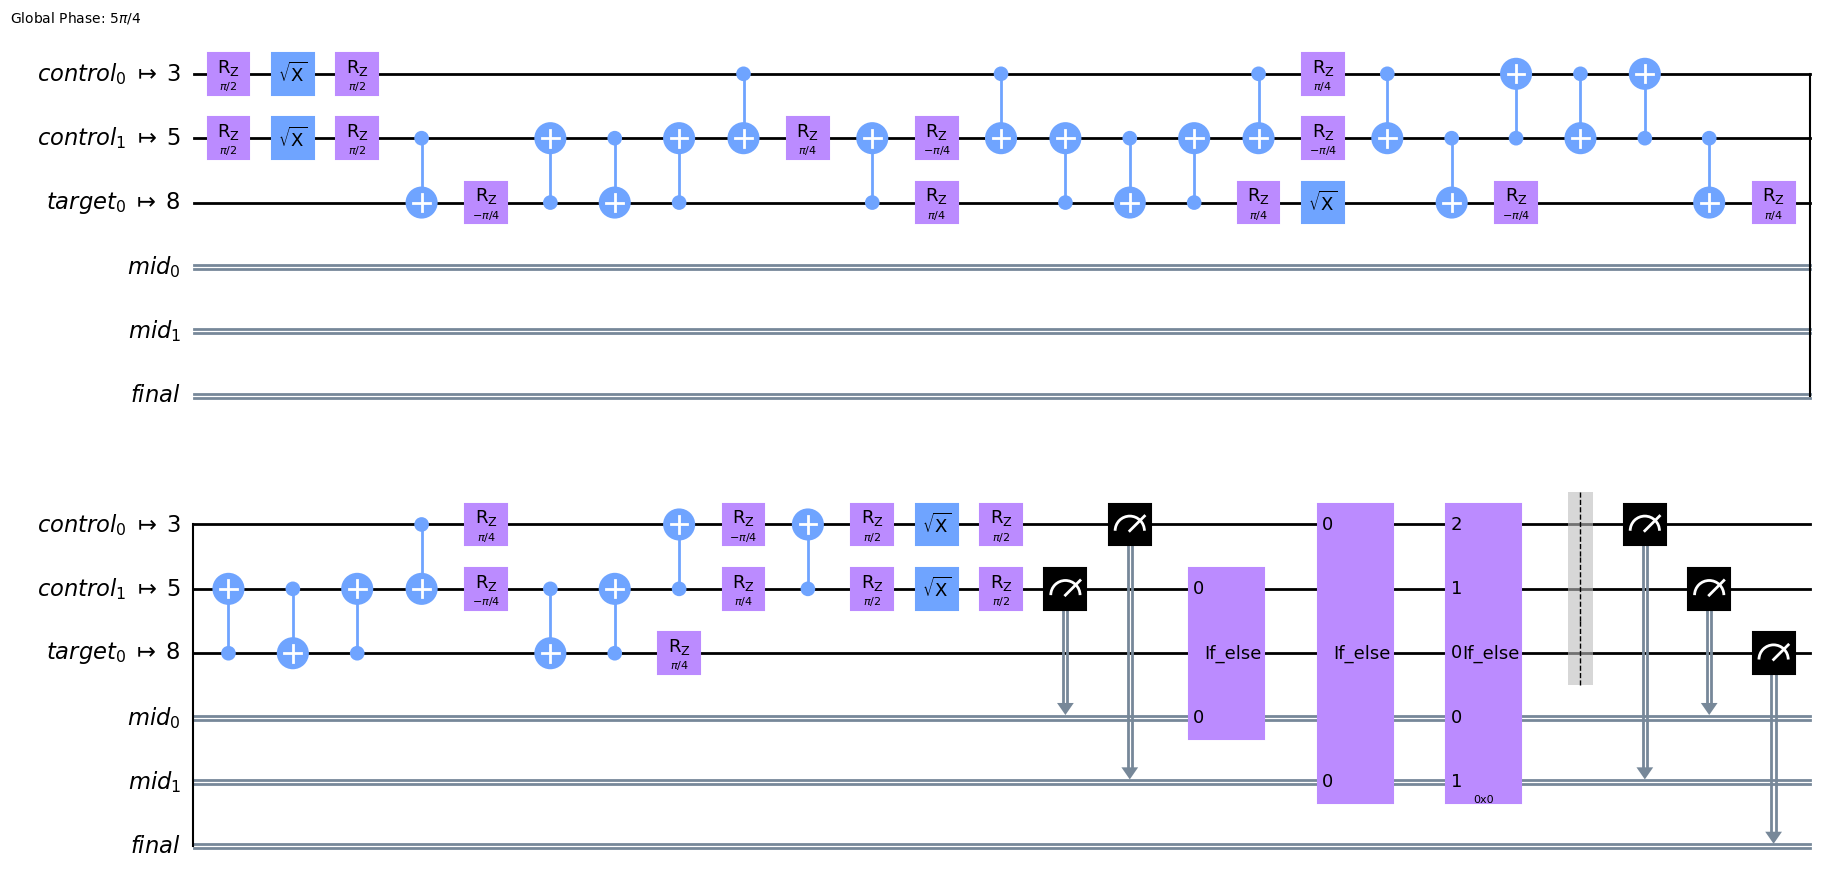

In [6]:
from qiskit import transpile

built = transpile(circuit, backend)
built.draw("mpl", cregbundle=False, idle_wires=False)

Now that we have built the circuit, we execute it on hardware by giving it to the backend's `run` method.  This returns a handle to an asynchronous job object. Calling its result method will block until the result is available, and then return it.

First, though, we can confirm, using Qiskit Aer, that we're producing the results we expect to see.  The preparation has a success probability of $5/8$, and we repeat it up to `max_trials` times, so the probability of a successful result at the end is

$$
P_{\text{success}} = 1 - {\Bigl(1 - \frac58\Bigr)}^{\text{max trials}}
$$

In [7]:
1 - (1 - 5 / 8) ** max_trials

0.859375

Aer provides its own backend, which is capable of simulating the available basis gates in all active IBM devices, and can handle complex control flow.  We build the simulator backend using `AerSimulator`, and then use the standard `run` method, which behaves the same as the real hardware.  For demonstration purposes here, we do not load a noise model into the simulator, but use idealized operations.

In [8]:
from qiskit_aer import AerSimulator

sim = AerSimulator(method="statevector")
simulator_result = sim.run(built, shots=3000).result()
simulator_counts = simulator_result.get_counts()
simulator_counts

{'1 11': 141, '1 00': 505, '1 01': 154, '1 10': 136, '0 00': 2064}

A successful result is one in which the measurements on the two controls end in the `00` state.  Let's filter those out, and see how many successes will result.  This is a type of post-selection.  In the complete repeat-until-success circuit, with a dynamic `while` loop, we would not need this, as we would be guaranteed a success.  However, in the interim, we can use the probabilities to examine the quality of the output, and verify that the probabilities are what we expect.

In [9]:
import collections


def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)

    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value

    return successes, failures


sim_successes, sim_failures = marginalize_successes(simulator_counts)

# What percentage of the results were successful?
sum(sim_successes.values()) / sum(simulator_counts.values())

0.8563333333333333

This is consistent with what we expected to see, up to the statistical noise of the measurements.  We can also verify the statistics of the target qubit state, post-selected for only the
cases that have a heralded success.

The successful gate performs the operation

$$
R_X(\theta) = \cos\frac\theta2 - i\sin\frac\theta2 X,\quad\text{where $\cos\theta = \frac35$.}
$$

For an initial state of $\lvert0\rangle$, the probability of measuring $\lvert1\rangle$ after the successful operation is

$$
{\bigl\lvert \langle1\rvert R_X(\theta) \lvert0\rangle \bigr\rvert}^2 = \sin^2\Bigl(\frac\theta2\Bigr) = \frac15.
$$

We can extract this directly from our marginalized counts.

In [10]:
sim_successes["1"] / sum(sim_successes.values())

0.19657454262358895

Again, up to statistical noise, this looks correct.  Our circuit seems to be working, so let's run it on actual hardware.

We already prepared our `backend` at the beginning of this section, in order to do the transpilation of `circuit` into `built`.  All that is left is to run, using the familiar `backend.run`.  When using dynamic-circuits capabilities, the keyword argument `dynamic=True` should be given, to exercise the correct paths.

In [11]:
# Recall that `built = transpile(circuit, backend)`.
job = backend.run(built, dynamic=True)
job.job_id()

'cggtvbg51vfr6fth4h5g'

In [12]:
hardware_counts = job.result().get_counts()
hardware_counts

{'0 00': 2225,
 '0 01': 169,
 '0 10': 239,
 '0 11': 138,
 '1 00': 635,
 '1 01': 168,
 '1 10': 288,
 '1 11': 138}

We can perform the same marginalization as before to check what percentage of shots resulted in a successful gate creation.

In [13]:
hw_successes, hw_failures = marginalize_successes(hardware_counts)

expected_successes = 1 - (1 - 5 / 8) ** max_trials
actual_successes = sum(hw_successes.values()) / sum(hardware_counts.values())
print(
    f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}."
)

Expected success rate 0.859.  Actual rate 0.715.


There is more noise than with Aer's ideal simulator, but it's still a good result, especially considering all the mid-circuit measurements and conditionals that we have applied in our circuit.

We can also test the post-selected output state:

In [14]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.222.


## Final remarks

Our final circuit used mid-circuit measurements to do conditional resets and to repeat a trial setup several times, until it either succeeded or the maximum number of trials were exceeded.  This involved several complex dynamic-circuit capabilities:

- Mid-circuit measurements
- Blocks of quantum operations conditioned on mid-circuit measurements
- Conditional measurements
- Simulation of all of the above

In the end, we were able to use the standard Qiskit workflow - `transpile` and `backend.run` - to prepare, compile, and execute a complex dynamic circuit on real hardware.  We verified it with a simulation, and saw results that compare _very_ favorably with what we expected!

Of course, this was a somewhat artificial example.  Qiskit's transpiler would have been able to exactly synthesize the one-qubit operation we were approximating if we had simply applied it and used the regular path. However, this is not always the case with more complex algorithms.

We also encountered a few limitations of the current stack, which we worked around:

- `while` loops are not fully supported in hardware (but will be soon!), so we hard-coded a finite number of repeats ourselves.
- Conditional measurement results can be used in execution, but are not reported back to the caller, so we had to add extra measurements to ensure we retrieved the results.
- Qiskit was unable to represent a negative condition directly, so we had to use an empty `if` block with a populated `else` block.

The IBM Quantum and Qiskit teams are currently working on solutions to these limitations.

---

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table